In [2]:
# import cv2

import os
import errno
import numpy as np
import pandas as pd
import gzip
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter

import sys
# sys.path.append('/shareb/zliu/analysis/')
# from CHARMtools import imputation,Cell3D
# import imp
# imp.reload(imputation)
# imp.reload(Cell3D)
import seaborn as sns
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

import random
import cooler

import pickle
from sklearn.preprocessing import LabelEncoder

import tqdm
from multiprocessing import Pool
from functools import partial
from scipy.signal import convolve2d
from scipy import ndimage
from scipy.spatial import ConvexHull#处理凸包
from scipy.spatial.distance import pdist, squareform
from scipy import stats


from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import scipy

## 0.function

In [51]:
def point_cloud_rotation(point_cloud, x_angle=None,y_angle=None,z_angle=None):
    if x_angle:
        rotation_matrix = np.array([[1,0,0],[0,np.cos(x_angle),-np.sin(x_angle)],[0,np.sin(x_angle),np.cos(x_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if y_angle:
        rotation_matrix = np.array([[np.cos(y_angle),0,np.sin(y_angle)],[0,1,0],[-np.sin(y_angle),0,np.cos(y_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if z_angle:
        rotation_matrix = np.array([[np.cos(z_angle),-np.sin(z_angle),0],[np.sin(z_angle),np.cos(z_angle),0],[0,0,1]])
        point_cloud = np.dot(point_cloud,rotation_matrix)

    return point_cloud

def plot_metrics(x,xlabel,pearson,spearman,ssmi,rms,title,color):
    # line plot of corrs ssmis and rms vs width
    fig, axes = plt.subplots(1, 4, figsize=(10, 3),dpi=120)

    axes[0].plot(x, pearson, color=color)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Pearson corrs')
    axes[0].set_title('Pearson corrs')

    axes[1].plot(x, spearman, color=color)
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Spearman corrs')
    axes[1].set_title('Spearman corrs')

    axes[2].plot(x, ssmi, color=color)
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel('SSIM')
    axes[2].set_title('SSIM')

    axes[3].plot(x, rms, color=color)
    axes[3].set_xlabel(xlabel)
    axes[3].set_ylabel('RMSD')
    axes[3].set_title('RMSD')

    plt.tight_layout()
    plt.savefig(f"{title}.png")
    
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        

def plot_matrix(matrix,title,region_start,region_end,cmap,vmax,vmin):
    plt.figure(figsize=(4,4), facecolor='white')
    plt.imshow(matrix,
               extent=(region_start, region_end, region_end, region_start),
               interpolation='none', vmin=vmin, vmax=vmax, cmap=cmap)

    plt.title(title)
    ax = plt.gca()

    ax.yaxis.set_ticks_position('left')   # 设置y轴刻度仅在左侧显示
    ax.xaxis.set_ticks_position('bottom') # 设置x轴刻度仅在底部显
    format_ticks(ax)
    #show colorbar
    cbar = plt.colorbar()
    cbar.set_label(title)
    cbar.set_ticks([vmin,0,vmax])
    cbar.set_ticklabels([vmin,0,vmax])
    #设置cbar大小


def plot_single_matrix(matrix,cmap="fall",title=None,vmax=1,vmin=0):
    plt.figure(figsize=(8, 3),dpi=120)
    plt.subplot(1, 2, 1)
    plt.imshow(matrix, cmap=cmap,vmax=vmax,vmin=vmin)
    plt.colorbar(label=title)
    plt.title(title)

    
# def mat_cor_with_na(mat1,mat2):
#     # Calculate distance matrices
#     distance_matrix_1 = mat1.flatten()
#     distance_matrix_2 = mat2.flatten()

#     # Replace inf values with nan
#     distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
#     distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

#     # Remove any NaN values from both arrays (only where both have NaNs in the same position)
#     mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)

#     distance_matrix_1 = distance_matrix_1[mask]
#     distance_matrix_2 = distance_matrix_2[mask]

#     # Check if there are any remaining NaNs or infs
#     if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
#         raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

#     # Now you can safely call pearsonr
#     pearsonr_value,_ = stats.pearsonr(distance_matrix_1, distance_matrix_2)
#     spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)
#     normalized_mat1 = (mat1 - np.nanmean(mat1)) / np.nanstd(mat1)
#     normalized_mat2 = (mat2 - np.nanmean(mat2)) / np.nanstd(mat2)
#     normalized_mat1[np.isnan(normalized_mat1)] = 0
#     normalized_mat2[np.isnan(normalized_mat2)] = 0
#     ssmis = ssim(normalized_mat1, normalized_mat2)
#     mse = mean_squared_error(normalized_mat1, normalized_mat2)

#     return [pearsonr_value,spearmanr_value,ssmis,mse]
def mat_cor_with_na(mat1,mat2,sample=False):
    # Calculate distance matrices
    distance_matrix_1 = mat1.flatten()
    distance_matrix_2 = mat2.flatten()

    # Replace inf values with nan
    distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
    distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)

    distance_matrix_1 = distance_matrix_1[mask]
    distance_matrix_2 = distance_matrix_2[mask]

    #sample 
    if sample:
        sample_index = np.random.choice(len(distance_matrix_1), sample, replace=False)
        distance_matrix_1 = distance_matrix_1[sample_index]
        distance_matrix_2 = distance_matrix_2[sample_index]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    # Now you can safely call pearsonr
    print(f"length is {len(distance_matrix_1)}")
    pearsonr_value,_ = stats.pearsonr(distance_matrix_1, distance_matrix_2)
    spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)
    normalized_mat1 = (mat1 - np.nanmean(mat1)) / np.nanstd(mat1)
    normalized_mat2 = (mat2 - np.nanmean(mat2)) / np.nanstd(mat2)
    normalized_mat1[np.isnan(normalized_mat1)] = 0
    normalized_mat2[np.isnan(normalized_mat2)] = 0
    ssmis = ssim(normalized_mat1, normalized_mat2)
    mse = mean_squared_error(normalized_mat1, normalized_mat2)

    return [pearsonr_value,spearmanr_value,ssmis,mse]
def normalize_gam_matrix(gam_matrix, mean_slices):
    # 定义标准化后的矩阵
    normalized_matrix = np.zeros_like(gam_matrix)
    # 获取矩阵的行数和列数
    rows, cols = gam_matrix.shape
    # 遍历矩阵中的每个元素
    for i in range(rows):
        for j in range(cols):
            # 提取当前元素
            D = gam_matrix[i, j]
            # 计算 f_a 和 f_b
            f_a = mean_slices[i]
            f_b = mean_slices[j]

            # 应用标准化规则
            if D < 0:
                normalized_matrix[i, j] = min(f_a * f_b, (1 - f_a) * (1 - f_b))
            else:
                normalized_matrix[i, j] = min(f_b * (1 - f_a), f_a * (1 - f_b))

    return normalized_matrix

def generate_spheres(tdg_path, CpG_df, radius, sphere_num):
    tdg = pd.read_csv(tdg_path,sep="\t",header = None)
    tdg.columns = ["chrom","start","x","y","z"]
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000

    spheres = []
    for _ in range(sphere_num):

        # Randomly rotate the point cloud
        rotated = point_cloud_rotation(tdg[["x", "y", "z"]].values,
                                       x_angle=np.random.uniform(0, 2*np.pi),
                                       y_angle=np.random.uniform(0, 2*np.pi),
                                       z_angle=np.random.uniform(0, 2*np.pi))

        tdg_temp = tdg[["chrom", "pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:, 0], y=rotated[:, 1], z=rotated[:, 2])

        # Generate a random center point for the sphere
        x_center = np.random.uniform(tdg_temp["x"].min(), tdg_temp["x"].max())
        y_center = np.random.uniform(tdg_temp["y"].min(), tdg_temp["y"].max())
        z_center = np.random.uniform(tdg_temp["z"].min(), tdg_temp["z"].max())

        # Determine which bins are within the radius of the sphere
        tdg_temp["distance"] = np.sqrt((tdg_temp["x"] - x_center) ** 2 + 
                                       (tdg_temp["y"] - y_center) ** 2 + 
                                       (tdg_temp["z"] - z_center) ** 2)
        
        sphere = tdg_temp.query('distance <= @radius').assign(insphere=lambda x: 1)[["chrom", "pos", "insphere"]]

        # Merge with CpG_df
        sphere = pd.merge(CpG_df, sphere, how="left").fillna(0)
        spheres.append(sphere["insphere"].values)

    return spheres


def generate_spheres_size(tdg_path, CpG_df, radius_mean, radius_std, sphere_num):
    tdg = pd.read_csv(tdg_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000
    spheres = []
    sphere_sizes = []

    for _ in range(sphere_num):
        rotated = point_cloud_rotation(tdg[["x", "y", "z"]].values,
                                       x_angle=np.random.uniform(0, 2*np.pi),
                                       y_angle=np.random.uniform(0, 2*np.pi),
                                       z_angle=np.random.uniform(0, 2*np.pi))

        tdg_temp = tdg[["chrom", "pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:, 0], y=rotated[:, 1], z=rotated[:, 2])

        x_center = np.random.uniform(tdg_temp["x"].min(), tdg_temp["x"].max())
        y_center = np.random.uniform(tdg_temp["y"].min(), tdg_temp["y"].max())
        z_center = np.random.uniform(tdg_temp["z"].min(), tdg_temp["z"].max())

        tdg_temp["distance"] = np.sqrt((tdg_temp["x"] - x_center) ** 2 + 
                                       (tdg_temp["y"] - y_center) ** 2 + 
                                       (tdg_temp["z"] - z_center) ** 2)
        radius = 0
        while radius <= 0:
            pick_value = np.random.normal(radius_mean, radius_std)
            if pick_value > radius_mean:
                radius = pick_value

        sphere = tdg_temp.query('distance <= @radius').assign(insphere=lambda x: 1)[["chrom", "pos", "insphere"]]
        sphere = pd.merge(CpG_df, sphere, how="left").fillna(0)
        spheres.append(sphere["insphere"].values)
        sphere_sizes.append(len(sphere[sphere["insphere"] == 1]))

    return spheres, sphere_sizes

## bin

In [4]:
resolution = 40000
ref = "mm9"
df_mm = pd.read_csv(f"/shareb/mliu/HiMulti/ref_data/{ref}.chrom.sizes",sep="\t",header=None)
df_mm.columns = ['chrom','size']
df_mm = df_mm.query("chrom!='chrX' and chrom != 'chrY'")


bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")

df_bin_mm9_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)
df_bin_mm9_40kb.index = range(len(df_bin_mm9_40kb))


# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
chr_list = list(bin_table_df['chrom'].unique())

## SPRITE

In [5]:
#public data
sprite_data_dir = "/shareb/mliu/HiMulti/data/SPRITE"
filename = "mouse_chr4_40kb_all_nover2.txt"
sprite_data = pd.read_csv(os.path.join(sprite_data_dir,filename),sep="\t",header=None)
sprite_data = np.array(sprite_data)
sprite_data_log = np.log10(sprite_data)
print(sprite_data_log.shape)

(3891, 3891)


/tmp/ipykernel_334150/2539522062.py:6: RuntimeWarning: divide by zero encountered in log10
  sprite_data_log = np.log10(sprite_data)


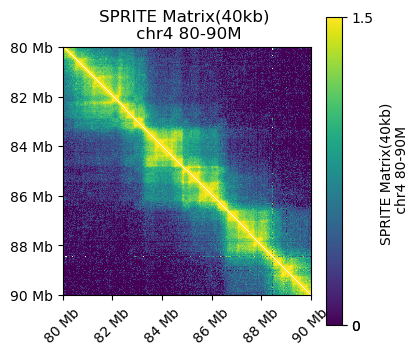

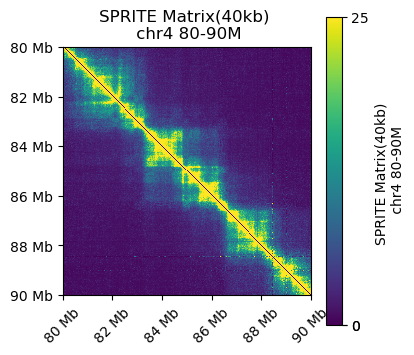

In [5]:
example_chr = "chr4"
start_pos = 80000000
end_pos = 90000000
hoxa_loc = f"{example_chr}:{start_pos}-{end_pos}"
start_pos_str = f"{start_pos//1000000}M"
end_pos_str = f"{end_pos//1000000}M"
start_idx = bin_table_df.query("chrom==@example_chr").reset_index().query("@start_pos >= start and @start_pos <= stop").index[0]
end_idx = bin_table_df.query("chrom==@example_chr").reset_index().query("@end_pos >= start and @end_pos <= stop").index[0]

plot_matrix(sprite_data_log[start_idx:end_idx,start_idx:end_idx],"SPRITE Matrix(40kb) \n chr4 80-90M",start_pos,end_pos,"viridis",vmax=1.5,vmin=0)
plot_matrix(sprite_data[start_idx:end_idx,start_idx:end_idx],"SPRITE Matrix(40kb) \n chr4 80-90M",start_pos,end_pos,"viridis",vmax=25,vmin=0)

## metadata

In [6]:
metadata = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0728/stat/stat_0728.csv")
cellnames1 = metadata[metadata['cellname'].str.startswith('d0')].query("`20k` < 1.5 & cellname != 'd0C3' & cellname != 'd0C5'")['cellname'].values
print(f"There are {len(cellnames1)} mESC cells")## 切一片

import pickle
with open('../mESC2_cellname.pkl', 'rb') as file:
    cellnames2 = pickle.load(file)
print(f"There are {len(cellnames2)} mESC cells")## 切一片

There are 38 mESC cells
There are 192 mESC cells


## Hi-C

In [7]:
resolution = 40000
region = "chr4(mat)"
clr_path = "/shareb/mliu/HiMulti/data/mESC2/mm9/cool/mESC2_mm9_40kb.cool"
clr = cooler.Cooler(clr_path)
mat_40k = clr.matrix(balance=False).fetch(region)#normalize之后的

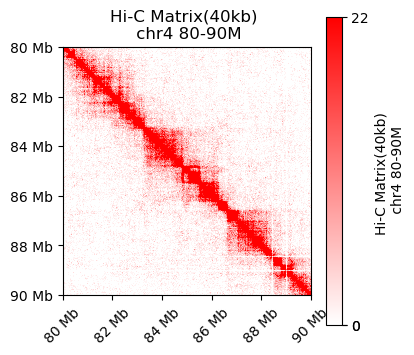

In [8]:
example_chr = "chr4"
start_pos = 80000000
end_pos = 90000000
hoxa_loc = f"{example_chr}:{start_pos}-{end_pos}"
start_pos_str = f"{start_pos//1000000}M"
end_pos_str = f"{end_pos//1000000}M"
start_idx = bin_table_df.query("chrom==@example_chr").reset_index().query("@start_pos >= start and @start_pos <= stop").index[0]
end_idx = bin_table_df.query("chrom==@example_chr").reset_index().query("@end_pos >= start and @end_pos <= stop").index[0]
                             
plot_matrix(mat_40k[start_idx:end_idx,start_idx:end_idx],"Hi-C Matrix(40kb) \n chr4 80-90M",start_pos,end_pos,fruitpunch,vmax=22,vmin=0)
# plot_matrix(mat_hic_40k[start_idx:end_idx,start_idx:end_idx],cmap=fruitpunch,title="Hi-C Matrix(100kb) \n chr4(pat) 80-90M",start_pos,end_pos,vmax=14,vmin=0)
# plot_single_matrix(mat_hic_log[start_idx:end_idx,start_idx:end_idx],cmap=fruitpunch,title="Hi-C Matrix(100kb) \n chr10(pat) 80M-90M",vmax=0.1,vmin=0)

In [55]:
pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(mat_40k,sprite_data) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

# pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(mat_hic_log,sprite_data_log) 
# print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

length is 15139881
pearsonr_value is 0.540970261805628
spearmanr_value is 0.34787451398837305
ssmis is 0.2898453869245706
mse is 0.9180594763889405


## 3dg Matrix

In [7]:
tdg_mm9_40kb_dir = "/shareb/mliu/HiMulti/data/mESC2/mm9/processed_tdg"
tdg_paths_40k2_mm9 = [f"{tdg_mm9_40kb_dir}/{file}" for file in os.listdir(tdg_mm9_40kb_dir)]
print(len(tdg_paths_40k2_mm9))
chrom_legnth_path_mm9 = "/shareb/mliu/HiMulti/ref_data/dip.len.mm9"

191


## 数量

In [11]:
#先看一下数量
df_bin = df_bin_mm9_40kb
sphere_num_list = np.linspace(1,200,5,dtype=int)
region = "chr4(mat)"
region_local = "chr4(mat):80000000-90000000"
silico_sprite_list = []
silico_sprite_local_list = []

for sphere_num in sphere_num_list:
    
    cluster_results = []
 
    for tdg_path in tqdm.tqdm(tdg_paths_40k2_mm9):
        cellname = tdg_path.split('/')[-2]
        cluster_result = generate_spheres(tdg_path, CpG_df=df_bin, radius=2, sphere_num=sphere_num)
        cluster_results.append(cluster_result)
    
    clusters = np.array([item for sublist in cluster_results for item in sublist]).T
    
    mat_index = df_bin[df_bin['chrom'] == region.split(':')[0]].index
    cluster_temp = clusters[mat_index,:]
    mean_slices = cluster_temp.mean(axis=1)
    mean_both = cluster_temp @ cluster_temp.T / cluster_temp.shape[1]
    mean_product = np.outer(mean_slices, mean_slices)
    sprite_matrix = mean_both - mean_product
    silico_sprite_list.append(sprite_matrix)

    mat_index_local = df_bin[df_bin['chrom'] == region_local.split(':')[0]].query('start >= {} & stop <= {}'.format(region_local.split(':')[1].split('-')[0], region_local.split(':')[1].split('-')[1])).index
    cluster_temp_local = clusters[mat_index_local,:]
    mean_slices_local = cluster_temp_local.mean(axis=1)
    mean_both_local = cluster_temp_local @ cluster_temp_local.T / cluster_temp_local.shape[1]
    mean_product_local = np.outer(mean_slices_local, mean_slices_local)
    sprite_matrix_local = mean_both_local - mean_product_local
    silico_sprite_local_list.append(sprite_matrix_local)


100%|█████████████████████████████████████████| 191/191 [18:43<00:00,  5.88s/it]


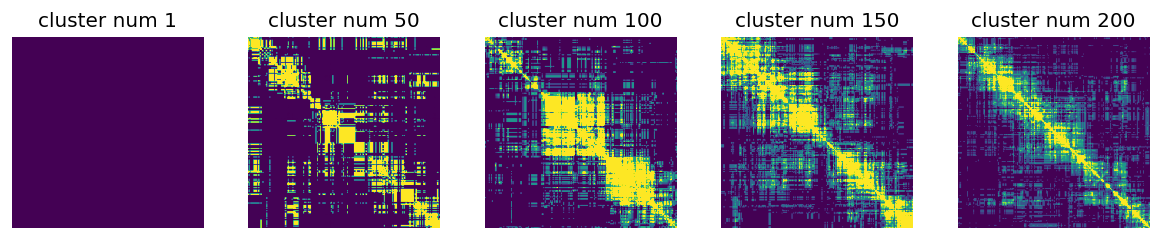

In [18]:
num_columns = len(sphere_num_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (cluster_num, img_data) in enumerate(zip(sphere_num_list, silico_sprite_local_list)):
    ax[i].imshow(img_data, cmap='viridis',vmax=0.0001)  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'cluster num {cluster_num}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')

plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)



(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881


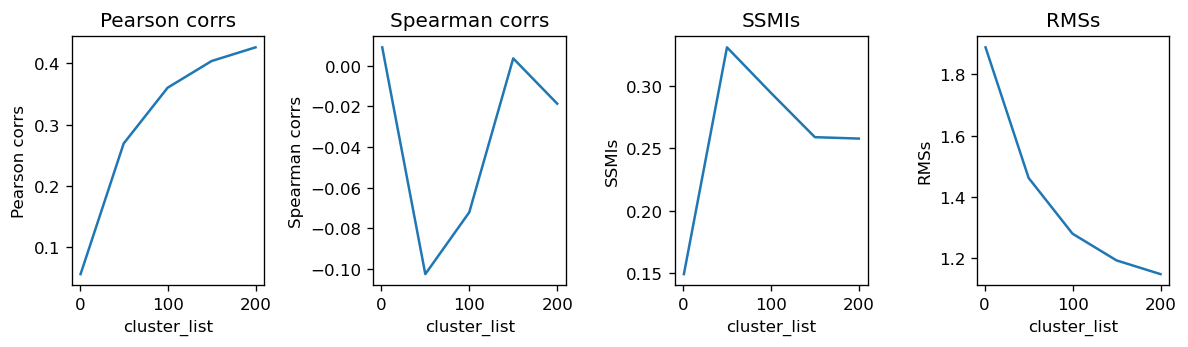

In [19]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in silico_sprite_list:
    mat1 = i
    mat2 = sprite_data
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2)

    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])

slice_width_stats = pd.DataFrame({'cluster_list':sphere_num_list,
                                'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})
plot_metrics(slice_width_stats['cluster_list'],"cluster_list",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'],"different_num2")


## 半径

In [24]:
df_bin = df_bin_mm9_40kb
R_list = np.linspace(0.5,6,5)
region = "chr4(mat)"
region_local = "chr4(mat):80000000-90000000"

silico_sprite_list = []
silico_sprite_local_list = []

for R in R_list:
    
    cluster_results = []
    cluster_sizes = []
    for tdg_path in tqdm.tqdm(tdg_paths_40k2_mm9):
        cellname = tdg_path.split('/')[-2]
        std = 1
        cluster_result, cluster_size = generate_spheres_size(tdg_path, df_bin, R, std, 20)
        cluster_results.append(cluster_result)
        cluster_sizes.append(cluster_size)

    clusters = np.array([item for sublist in cluster_results for item in sublist]).T
    mat_index = df_bin[df_bin['chrom'] == region.split(':')[0]].index
    cluster_temp = clusters[mat_index,:]
    mean_slices = cluster_temp.mean(axis=1)
    mean_both = cluster_temp @ cluster_temp.T / cluster_temp.shape[1]
    mean_product = np.outer(mean_slices, mean_slices)
    sprite_matrix = mean_both - mean_product
    silico_sprite_list.append(sprite_matrix)

    mat_index_local = df_bin[df_bin['chrom'] == region_local.split(':')[0]].query('start >= {} & stop <= {}'.format(region_local.split(':')[1].split('-')[0], region_local.split(':')[1].split('-')[1])).index
    cluster_temp_local = clusters[mat_index_local,:]
    mean_slices_local = cluster_temp_local.mean(axis=1)
    mean_both_local = cluster_temp_local @ cluster_temp_local.T / cluster_temp_local.shape[1]
    mean_product_local = np.outer(mean_slices_local, mean_slices_local)
    sprite_matrix_local = mean_both_local - mean_product_local
    silico_sprite_local_list.append(sprite_matrix_local)


100%|█████████████████████████████████████████| 191/191 [02:28<00:00,  1.29it/s]


In [23]:
silico_matrix_list

[]

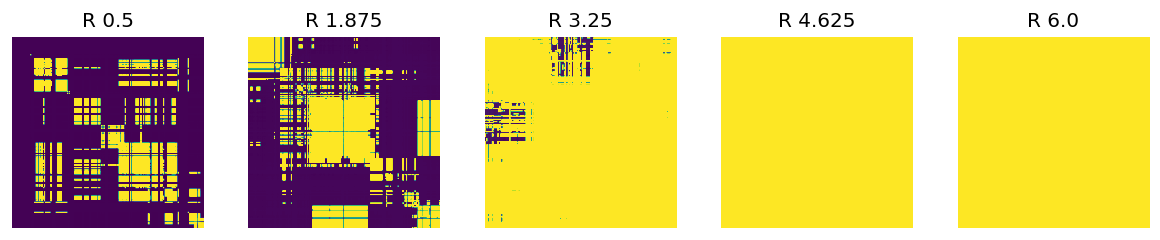

In [26]:
num_columns = len(R_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (R, img_data) in enumerate(zip(R_list, silico_sprite_local_list)):
    ax[i].imshow(img_data, cmap='viridis',vmax=0.0001)  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'R {R}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')

plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)



In [28]:
pcorrs_S = []
scorrs_S = []
ssmis_S = []
rms_S = []

for i in silico_sprite_list:
    mat1= i
    mat2 = sprite_data
    cor_list = mat_cor_with_na(mat1,mat2)
    pcorrs_S.append(cor_list[0])
    scorrs_S.append(cor_list[1])
    ssmis_S.append(cor_list[2])
    rms_S.append(cor_list[3])

# build pd.df
slice_width_stats = pd.DataFrame({'R_list':R_list,
                                  'pcorrs_S':pcorrs_S,'scorrs_S':scorrs_S, 'ssmis_S':ssmis_S, 'rms_S':rms_S,
                                 }
                                )


plot_metrics(slice_width_stats['R_list'],"R list",slice_width_stats['pcorrs_S'],slice_width_stats['scorrs_S'],slice_width_stats['ssmis_S'],slice_width_stats['rms_S'])

length is 15139881
length is 15139881
length is 15139881
length is 15139881
length is 15139881


TypeError: plot_metrics() missing 1 required positional argument: 'title'

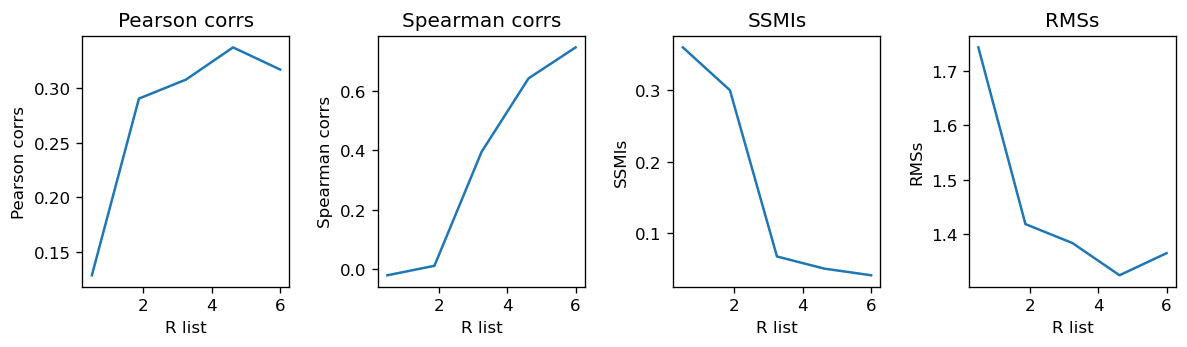

In [31]:
plot_metrics(slice_width_stats['R_list'],"R list",slice_width_stats['pcorrs_S'],slice_width_stats['scorrs_S'],slice_width_stats['ssmis_S'],slice_width_stats['rms_S'],None)

In [ ]:
#不同半径的


## 聚类

In [9]:
def load_tdg(file_path):
    tdg = pd.read_csv(file_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000  # Adjusting position
    return tdg

def assign_bins(df, bin_size=40000):
    df['bin'] = df['start'] // bin_size
    return df


def crosslink_beads(df, n_clusters, pc):
    coords = df[['x', 'y', 'z']].values
    #至少需要2个点才能成簇
    clustering = KMeans(n_clusters=n_clusters).fit(coords)
    # clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(coords)
    df['cluster'] = clustering.labels_
    # clustering = GaussianMixture(n_components=n_clusters).fit(coords)
    # labels = clustering.predict(coords)
    # df['cluster'] = labels
    df = df[df['cluster'] != -1]  # Remove noise points
    df = df[df['cluster'].map(lambda _: np.random.rand() < pc)]  # Apply crosslinking efficiency
    return df
def crosslink_beads_dbscan(df,eps):
    coords = df[['x', 'y', 'z']].values
    #最重要的是Eps
    clustering = DBSCAN(eps=eps, min_samples=3).fit(coords)
    df['cluster'] = clustering.labels_
    df = df[df['cluster'] != -1]  # Remove noise points
    return df
pc = 1
pb = 1 #成功的概率
pl = 1

In [34]:


chr = "chr4(mat)"

avg_contact_matrix_list = []
n_cluster_list = np.linspace(5,250,10,dtype=int)
for n_cluster in n_cluster_list:
    print(f"n_cluster {n_cluster}")
    contact_matrix_list = []
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))
    sc_sprite_list = []
    for tdg_path in tqdm.tqdm(tdg_paths_40k2_mm9):
        cellname = tdg_path.split('/')[-1]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        df_tdg_chr = crosslink_beads(df_tdg_chr, n_clusters=n_cluster, pc=pc)#可能会损失bin
        
        df_tdg_chr = df_tdg_chr[df_tdg_chr['cluster'].map(lambda _: np.random.rand() < pb)]

        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr.groupby('cluster')
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    avg_contact_matrix_list.append(avg_contact_matrix)

n_cluster 5


 72%|█████████████████████████████▍           | 137/191 [04:17<01:42,  1.91s/it]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [06:07<00:00,  1.92s/it]


n_cluster 32


 72%|█████████████████████████████▍           | 137/191 [00:55<00:21,  2.53it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:30<00:00,  2.12it/s]


n_cluster 59


 72%|█████████████████████████████▍           | 137/191 [00:42<00:16,  3.36it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (59). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:12<00:00,  2.62it/s]


n_cluster 86


 72%|█████████████████████████████▍           | 137/191 [00:39<00:14,  3.68it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (86). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:07<00:00,  2.81it/s]


n_cluster 113


 72%|█████████████████████████████▍           | 137/191 [00:37<00:14,  3.73it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:05<00:00,  2.91it/s]


n_cluster 141


 72%|█████████████████████████████▍           | 137/191 [00:37<00:14,  3.72it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (141). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:05<00:00,  2.92it/s]


n_cluster 168


 72%|█████████████████████████████▍           | 137/191 [00:37<00:14,  3.81it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (168). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:05<00:00,  2.90it/s]


n_cluster 195


 72%|█████████████████████████████▍           | 137/191 [00:38<00:13,  3.86it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (195). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:06<00:00,  2.86it/s]


n_cluster 222


 72%|█████████████████████████████▍           | 137/191 [00:38<00:14,  3.72it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (222). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 88%|████████████████████████████████████▎    | 169/191 [00:54<00:06,  3.63it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (220) found smaller than n_clusters (222). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:07<00:00,  2.85it/s]


n_cluster 250


 72%|█████████████████████████████▍           | 137/191 [00:39<00:14,  3.76it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (250). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 88%|████████████████████████████████████▎    | 169/191 [00:55<00:06,  3.48it/s]/share/home/mliu/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (220) found smaller than n_clusters (250). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|█████████████████████████████████████████| 191/191 [01:08<00:00,  2.79it/s]


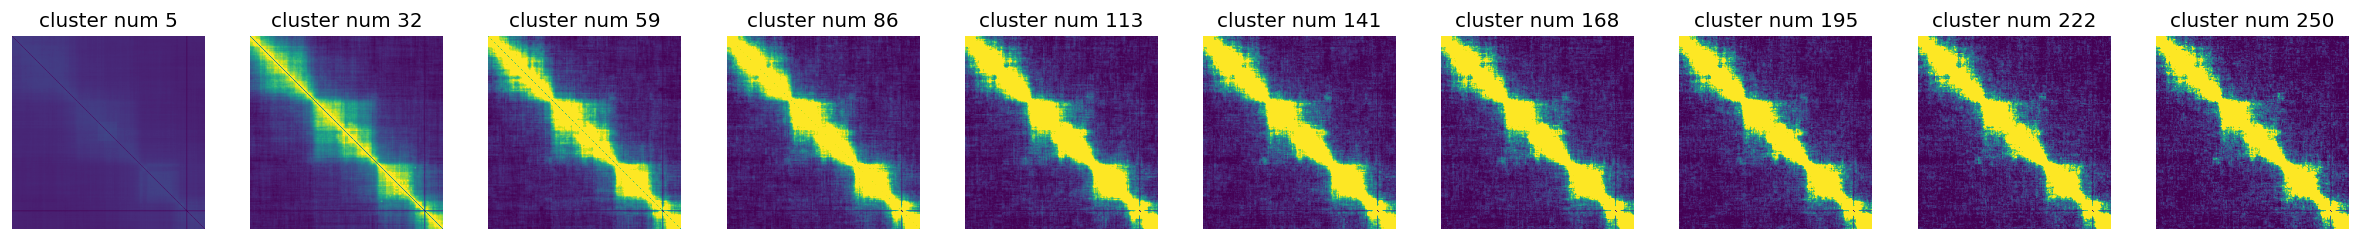

In [37]:
num_columns = len(n_cluster_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (n_cluster, img_data) in enumerate(zip(n_cluster_list, avg_contact_matrix_list)):
    matrix_region = img_data[start_idx:end_idx,start_idx:end_idx]
    ax[i].imshow(matrix_region, cmap='viridis',vmax=0.01)  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'cluster num {n_cluster}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')
    
plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)

In [39]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in avg_contact_matrix_list:
    mat1 = i
    mat2 = sprite_data
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)

    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])

slice_width_stats = pd.DataFrame({'n_cluster_list':n_cluster_list,
                                'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})


(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881


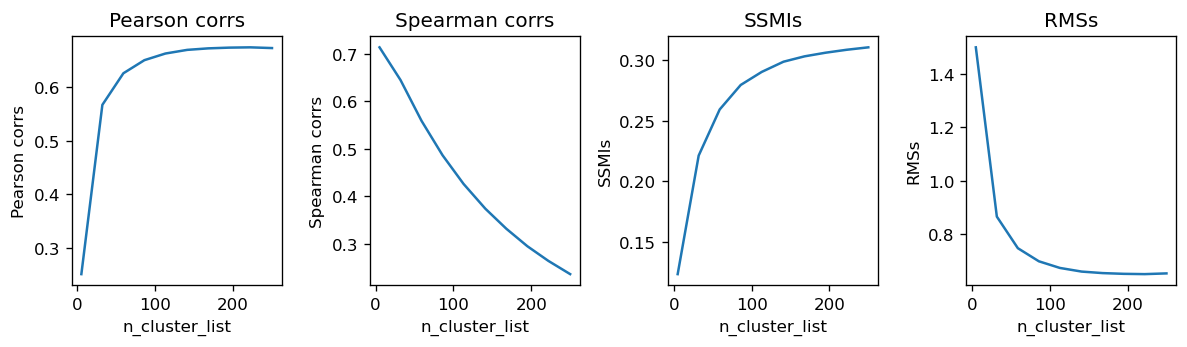

In [40]:
plot_metrics(slice_width_stats['n_cluster_list'],"n_cluster_list",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'],"different_num2")

In [16]:
#dbscan
chr = "chr4(mat)"

avg_contact_matrix_list = []
cluster_size_lists = []
eps_list = [0.6]
for eps in eps_list:
    print(f"eps {eps}")
    contact_matrix_list = []
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))
    sc_sprite_list = []
    
    cluster_size_cell = []
    for tdg_path in tdg_paths_40k2_mm9:
        
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,eps)#可能会损失bin
        df_tdg_chr = pd.merge(df_tdg_chr[['chrom','pos','start','x','y','z','bin']],df_tdg_chr_result[['bin','cluster']],on="bin",how="left")
        
        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr_result.groupby('cluster')
        
        cluster_size_list = []
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            cluster_size_list.append(cluster_size)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
        cluster_size_cell.append(cluster_size_list)
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    avg_contact_matrix_list.append(avg_contact_matrix)
    cluster_size_lists.append(cluster_size_cell)

eps 0.6


In [25]:
len(cluster_size_lists[0])
flattened_list = [item for sublist in cluster_size_lists[0] for item in sublist]

In [31]:
median = np.median(flattened_list)

# 计算下四分位数 (Q1) 和上四分位数 (Q3)
q1 = np.percentile(flattened_list, 25)
q3 = np.percentile(flattened_list, 75)

# 输出结果
print(f"中位数: {median}")
print(f"下四分位数 (Q1): {q1}")
print(f"上四分位数 (Q3): {q3}")

中位数: 4.0
下四分位数 (Q1): 3.0
上四分位数 (Q3): 7.0


In [86]:

group1_list = [i for i in flattened_list if i <= 3]
group2_list = [i for i in flattened_list if i > 3 and i <= 8]
group3_list = [i for i in flattened_list if i > 8 and i <= 15]
group4_list = [i for i in flattened_list if i > 15 and i <= 80]
group5_list = [i for i in flattened_list if i >80]

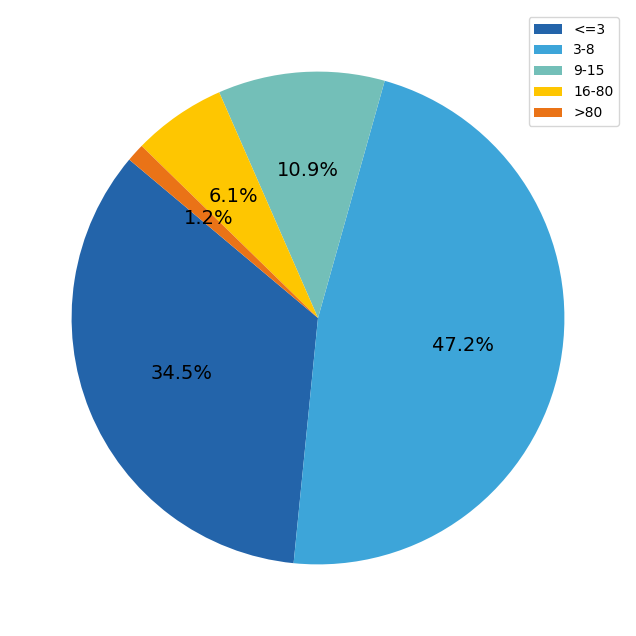

In [106]:
sizes = [len(group1_list), len(group2_list), len(group3_list), len(group4_list), len(group5_list)]
labels = ['<=3', '3-8', '9-15', '16-80', '>80']
mycolors = ["#2364aa", "#3da5d9", "#73bfb8", "#fec601",'#ea7317']
# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(sizes, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14},colors=mycolors)

# 添加图例
plt.legend(labels, loc="best")
plt.show()

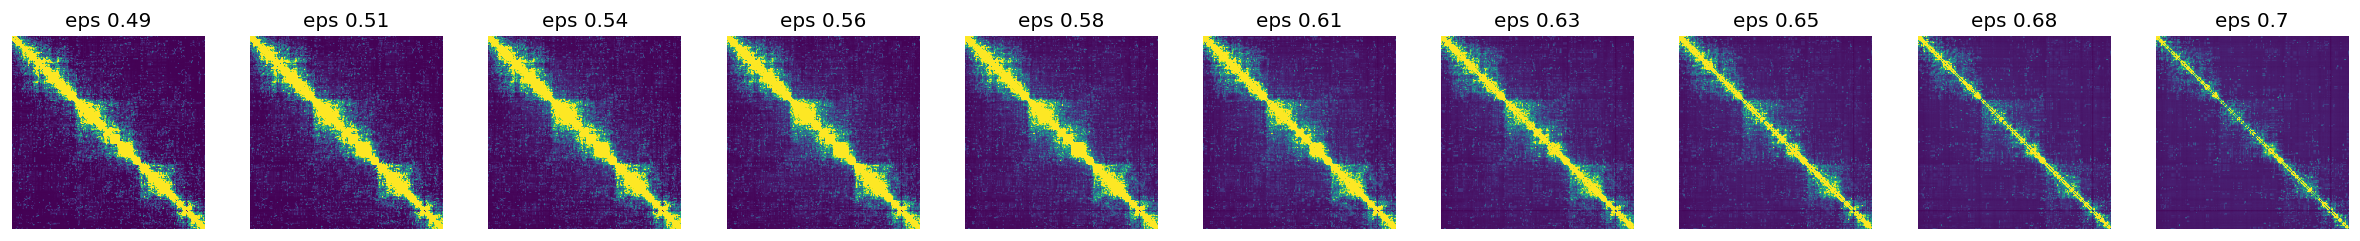

In [67]:
num_columns = len(avg_contact_matrix_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (n_cluster, img_data) in enumerate(zip(eps_list, avg_contact_matrix_list)):
    matrix_region = img_data[start_idx:end_idx,start_idx:end_idx]
    ax[i].imshow(matrix_region, cmap='viridis',vmax=0.008)  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'eps {np.round(n_cluster,2)}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')
    
plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)

In [65]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in avg_contact_matrix_list:
    mat1 = i
    mat2 = sprite_data
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)

    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])

slice_width_stats = pd.DataFrame({'eps_list':eps_list,
                                'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})


(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881
(3891, 3891) (3891, 3891)
length is 15139881


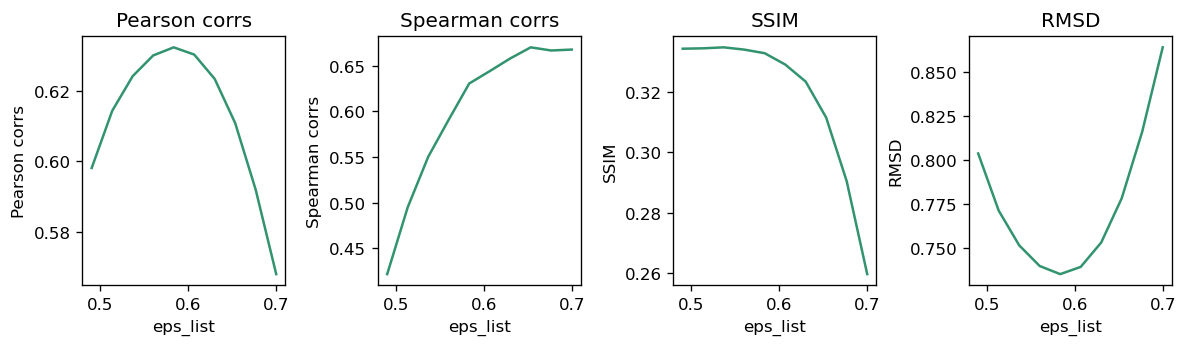

In [66]:
plot_metrics(slice_width_stats['eps_list'],"eps_list"
             ,slice_width_stats['pcorrs_D']
             ,slice_width_stats['scorrs_D']
             ,slice_width_stats['ssmis_D']
             ,slice_width_stats['rms_D'],"different_num2"
             ,"#32936f")

生成table

In [107]:
#创建一个字典，第一个key是细胞，下一级key是cluster，保存该cluster中的bin

# n_cluster = 220
eps = 0.6
for chr in chr_list:
    chr = f"{chr}(mat)"
    print(chr)
    cluster_dict = {}
    
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))

    contact_matrix_list = []
    for tdg_path in tdg_paths_40k2_mm9:
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        #每个染色体分别处理
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        # df_tdg_chr = crosslink_beads(df_tdg_chr, n_clusters=n_cluster, pc=pc)#可能会损失bin
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,eps)
        df_tdg_chr = df_tdg_chr[df_tdg_chr['cluster'].map(lambda _: np.random.rand() < pb)]
        
        # 将数据存储到cluster字典中
        if cellname not in cluster_dict:
            cluster_dict[cellname] = {}
        for cluster_id, group in df_tdg_chr.groupby('cluster'):
            if cluster_id not in cluster_dict[cellname]:
                cluster_dict[cellname][cluster_id] = []
            cluster_dict[cellname][cluster_id].extend(group['bin'].tolist())


        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr.groupby('cluster')
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
    
    #所有细胞的平均
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    # np.save(f"silico_sprite_result/mESC2_kmeans220_{chr}.npy",avg_contact_matrix)
    np.save(f"silico_sprite_result/mESC2_dbscan_{chr}.npy",avg_contact_matrix)
    #保存字典
    # with open(f"silico_sprite_result/mESC2_kmeans220_{chr}.pkl", 'wb') as file:
    with open(f"silico_sprite_result/mESC2_dbscan_{chr}.pkl", 'wb') as file:
        pickle.dump(cluster_dict, file)

    

  

chr1(mat)
chr2(mat)
chr3(mat)
chr4(mat)
chr5(mat)
chr6(mat)
chr7(mat)
chr8(mat)
chr9(mat)
chr10(mat)
chr11(mat)
chr12(mat)
chr13(mat)
chr14(mat)
chr15(mat)
chr16(mat)
chr17(mat)
chr18(mat)
chr19(mat)
